In [122]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy
import torch
import pandas
import os
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 1.预处理数据
## 读取数据

In [123]:
# 读取CSV文件
# train.csv有价格，test.csv没有价格
train_data = pandas.read_csv("train.csv")
test_data = pandas.read_csv("test.csv")

print(train_data.shape,test_data.shape)

# 去掉第一列id的数据，目的是为了防止模型记住编号得到对应价格
all_features = pandas.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:-1]))
print(all_features.shape)

print(train_data.iloc[:5,:8])

(1460, 81) (1459, 80)
(2919, 79)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape
0   1          60       RL         65.0     8450   Pave   NaN      Reg
1   2          20       RL         80.0     9600   Pave   NaN      Reg
2   3          60       RL         68.0    11250   Pave   NaN      IR1
3   4          70       RL         60.0     9550   Pave   NaN      IR1
4   5          60       RL         84.0    14260   Pave   NaN      IR1


## 处理缺少值和属性

In [124]:

#提取全是数字的特征名字
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

#对数据做标准化处理,对应位置赋值
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
#这一部分定义了一个匿名函数（lambda 函数），它接受一个参数x 。在这里x代表正在处理的 DataFrame 的每一列。 

# 在标准化数据之后，将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

#`Dummy_na=True` 将“na”（缺失值）视为有效的特征值，并为其创建指示符特征。

# pandas.get_dummies把特征为类别值或离散值分成每一个特征为一个类别。
all_features = pandas.get_dummies(all_features, dummy_na = True)
print("all_features.shape:",all_features.shape)


all_features.shape: (2919, 331)


### apply()  方法： 
-  apply()  方法是 pandas 中的一个函数，用于沿着 DataFrame 或 Series 的某个轴应用一个函数。可以通过  axis  参数指定是按行（1）还是按列（0）应用函数。 
- 在这个例子中， apply()  被用于处理一个包含数值特征的 DataFrame，并将给定的 lambda 函数应用于每一列（默认情况下，apply() 是按列处理的）。 
### pandas.getdummies
### 示例： 
假设  all_features  中有一列  Color ，其值如下：

```
| Color   |
|---------|
| Red     |
| Blue    |
| Green   |
| NaN     |
```
执行  pandas.get_dummies(all_features, dummy_na=True)  后，结果可能是：
```
| Color_Blue | Color_Green | Color_Red | Color_nan |
|-------------|--------------|------------|-----------|
| 0           | 0            | 1          | 0         |
| 1           | 0            | 0          | 0         |
| 0           | 1            | 0          | 0         |
| 0           | 0            | 0          | 1         |
```
在这个结果中，每个颜色值都被转换为一个新的列，不同的颜色对应的列中填入1或0，表示该行数据是否属于该颜色。同时，缺失值（NaN）也被转化为  Color_nan  列，表示该行数据是否存在缺失值。这样处理后的数据就可以直接用于机器学习模型的训练。

## 分成训练集与测试集

In [125]:
n_train = train_data.shape[0]
# 前n_train行作为训练集
train_features = torch.tensor(all_features[:n_train].values, dtype = torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype = torch.float32)
# 把train.data价格一列作为训练集的标签，并reshape为一列的tensor
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype = torch.float32)
print(train_features.shape, test_features.shape, train_labels.shape)

torch.Size([1460, 331]) torch.Size([1459, 331]) torch.Size([1460, 1])


## 数据分批

In [126]:
#数据分批
batch_size = 16
dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_loader = torch.utils.data.DataLoader(dataset,                   # 数据
                                          batch_size = batch_size,    # 每个batch大小
                                          shuffle = True,             # 是否打乱数据
                                          num_workers = 0,            # 工作线程
                                          pin_memory = True)
print(f"每一批{len(next(iter(train_loader))[0])}个，一共{len(train_loader)}批")

每一批16个，一共92批


# 2.模型训练

## 定义神经网络

In [127]:
class MyNet(nn.Module):
    def __init__(self, in_put, hidden1, hidden2, hidden3, out_put):
        super().__init__()
        self.linear1 = nn.Linear(in_put, hidden1)
        self.linear2 = nn.Linear(hidden1, hidden2)
        self.linear3 = nn.Linear(hidden2, hidden3)
        self.linear4 = nn.Linear(hidden3, out_put)
    def forward(self, data):
        x  = self.linear1(data)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)
        x = torch.relu(x)
        x = self.linear4(x)
        return x

## 初始化神经网络

In [128]:
# 输入特征个数为训练集的列的个数
in_put = train_features.shape[1]
hidden1 , hidden2, hidden3, out_put = 256, 128, 16, 1
model = MyNet(in_put, hidden1, hidden2, hidden3, out_put).to(device)

# batch_size = 32, loss = MSELoss 0.17
# batch_size = 32, loss = L1Loss 0.15
# batch_size = 16, loss = MSELoss 0.16
# batch_size = 16, loss = L1loss 0.15
loss = nn.L1Loss()
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr)

In [129]:
print(model)

MyNet(
  (linear1): Linear(in_features=331, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=1, bias=True)
)


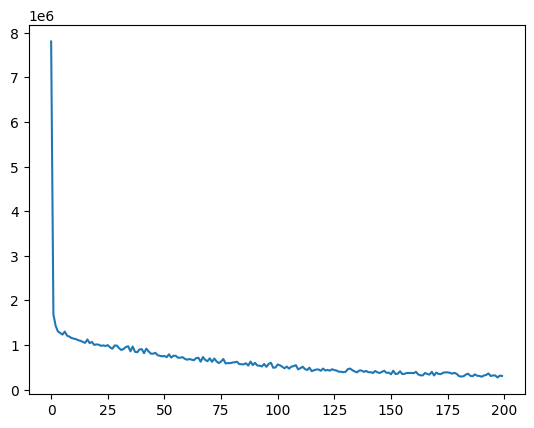

In [130]:
epochs = 200
def train(train_loader):
    train_ls = []
    for epoch in range(epochs):
        loss_sum = 0
        for train_batch, labels_batch in train_loader:
            train_batch, labels_batch = train_batch.to(device), labels_batch.to(device)
            #preds = torch.clamp(model(train_batch), 1, float('inf'))
            #l = loss(torch.log(preds), torch.log(labels_batch))
            l = loss(model(train_batch),labels_batch)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            loss_sum += l.item()
        train_ls.append(loss_sum)
    plt.plot(range(epochs), train_ls)
    plt.show()
train(train_loader)

In [131]:
def test(test_features):
    test_features = test_features.to(device)
    # 将计算图从当前张量中分离，防止在后续操作中计算梯度，并将tensor转换为numpy数组
    preds = model(test_features).detach().to("cpu").numpy()
    # squeeze()方法用于去除数组中维度为1的维度
    print(preds.shape, preds.squeeze().shape)
      
    #pandas.Series 创建新维度
    test_data['SalePrice'] = pandas.Series(preds.squeeze())
    
    #axis选择拼接的维度
    return pandas.concat([test_data['Id'], test_data['SalePrice']], axis = 1)
submission = test(test_features)
submission.to_csv('submission.csv', index=False)

(1459, 1) (1459,)
